In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist, cosine
from scipy.ndimage import convolve1d
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import normalize
import tensorflow as tf
from joblib import Parallel, delayed

from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors

import pandas as pd
import xarray as xr
from netCDF4 import Dataset, num2date, date2num
from datetime import datetime, timedelta
import os

import seaborn as sns
import cmocean as cmocn
import matplotlib.pyplot as plt

%matplotlib inline

2024-08-09 11:02:02.322190: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 11:02:02.352670: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 11:02:02.352701: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 11:02:02.354111: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 11:02:02.359348: I tensorflow/core/platform/cpu_feature_gua

In [2]:
ds = xr.open_dataset('../rainFlagRemovedBuoyDataBadQualityRemovedMatchup.nc')
df = ds.to_dataframe()
df_orig = df.copy()

In [3]:
list(df.keys())

['Wind Direction (TAO)',
 'WDIR_QC',
 'WDIR_DM',
 'Wind Speed (TAO)',
 'WSPD_QC',
 'WSPD_DM',
 'Zonal Wind Speed (TAO)',
 'Meridional Wind Speed (TAO)',
 'Sea Surface Temperature (TAO)',
 'SST_QC',
 'SST_DM',
 'Relative Humidity (TAO)',
 'RELH_QC',
 'RELH_DM',
 'Air Temperature (TAO)',
 'AIRT_QC',
 'AIRT_DM',
 'Neutral Wind Speed at 10m (TAO)',
 'Wind Speed at 10m (TAO)',
 'mean WSPD 20min',
 'std. dev. WSPD 20min',
 'mean WSPD_10N 20min',
 'std. dev. WSPD_10N 20min',
 'mean Ux_10N 20min',
 'std. dev. Ux_10N 20min',
 'mean Vy_10N 20min',
 'std. dev. Vy_10N 20min',
 'mean WDIR 20min',
 'std. dev. WDIR 20min',
 'mean WSPD 30min',
 'std. dev. WSPD 30min',
 'mean WSPD_10N 30min',
 'std. dev. WSPD_10N 30min',
 'mean Ux_10N 30min',
 'std. dev. Ux_10N 30min',
 'mean Vy_10N 30min',
 'std. dev. Vy_10N 30min',
 'mean WDIR 30min',
 'std. dev. WDIR 30min',
 'mean WSPD 40min',
 'std. dev. WSPD 40min',
 'mean WSPD_10N 40min',
 'std. dev. WSPD_10N 40min',
 'mean Ux_10N 40min',
 'std. dev. Ux_10N 40mi

In [7]:
df['cos(Wind Direction (QuikSCAT))'] = np.cos(np.deg2rad(df['Wind Direction (QuikSCAT)']))
df['sin(Wind Direction (QuikSCAT))'] = np.sin(np.deg2rad(df['Wind Direction (QuikSCAT)']))

df['cos(Wind Direction (TAO))'] = np.cos(np.deg2rad(df['Wind Direction (TAO)']))
df['sin(Wind Direction (TAO))'] = np.sin(np.deg2rad(df['Wind Direction (TAO)']))

df['cos(Direction Difference (QuikSCAT - TAO))'] = np.cos(np.deg2rad(df['Direction Difference (QuikSCAT - TAO)']))
df['sin(Direction Difference (QuikSCAT - TAO))'] = np.sin(np.deg2rad(df['Direction Difference (QuikSCAT - TAO)']))


for timeWindow in range(20,130,10):
    df[f'cos(Direction Difference (QuikSCAT - TAO {timeWindow} min mean))'] = np.cos(np.deg2rad(df[f'Direction Difference (QuikSCAT - TAO {timeWindow} min mean)']))
    df[f'sin(Direction Difference (QuikSCAT - TAO {timeWindow} min mean))'] = np.sin(np.deg2rad(df[f'Direction Difference (QuikSCAT - TAO {timeWindow} min mean)']))


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

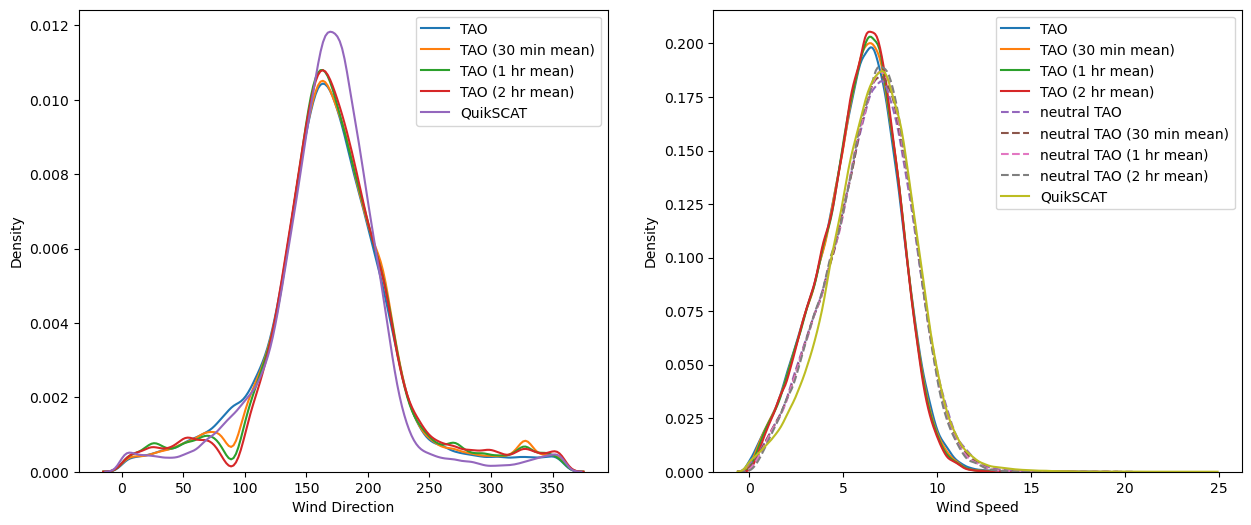

In [5]:
fig, axes = plt.subplots(ncols=2, figsize=(15,6))

ax = axes[0]
sns.kdeplot(df['Wind Direction (TAO)'], ax = ax, label = 'TAO')
sns.kdeplot(df['mean WDIR 30min'], ax = ax, label = 'TAO (30 min mean)')
sns.kdeplot(df['mean WDIR 60min'], ax = ax, label = 'TAO (1 hr mean)')
sns.kdeplot(df['mean WDIR 120min'], ax = ax, label = 'TAO (2 hr mean)')
sns.kdeplot(df['Wind Direction (QuikSCAT)'], ax = ax, label = 'QuikSCAT')
ax.set_xlabel('Wind Direction')
ax.legend()

ax = axes[1]
sns.kdeplot(df['Wind Speed (TAO)'], ax = ax, label = 'TAO')
sns.kdeplot(df['mean WSPD 30min'], ax = ax, label = 'TAO (30 min mean)')
sns.kdeplot(df['mean WSPD 60min'], ax = ax, label = 'TAO (1 hr mean)')
sns.kdeplot(df['mean WSPD 120min'], ax = ax, label = 'TAO (2 hr mean)')

sns.kdeplot(df['Neutral Wind Speed at 10m (TAO)'], linestyle="--", ax = ax, label = 'neutral TAO')
sns.kdeplot(df['mean WSPD_10N 30min'], linestyle="--", ax = ax, label = 'neutral TAO (30 min mean)')
sns.kdeplot(df['mean WSPD_10N 60min'], linestyle="--", ax = ax, label = 'neutral TAO (1 hr mean)')
sns.kdeplot(df['mean WSPD_10N 120min'], linestyle="--", ax = ax, label = 'neutral TAO (2 hr mean)')

sns.kdeplot(df['Wind Speed (QuikSCAT)'], ax = ax, label = 'QuikSCAT')
ax.set_xlabel('Wind Speed')
ax.legend()

PCA Components:
             PC1       PC2
0      -0.174402 -0.226977
1      -0.251414 -0.137215
2       0.208430  0.308837
3      -0.055270  0.052540
4      -0.108735 -0.101256
...          ...       ...
148722  0.671262  1.540344
148723  0.784363  1.627114
148724  0.151442  0.528912
148725 -0.971536 -0.456110
148726 -0.652852 -0.050185

[148727 rows x 2 columns]

Explained Variance Ratio:
PC1: 0.5104
PC2: 0.4896


Text(0.5, 1.0, 'Explained Variance by Principal Components')

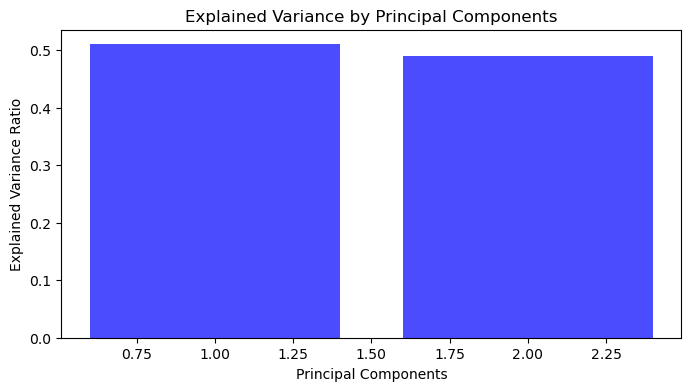

In [31]:
selectX = ['Speed Difference (QuikSCAT - TAO)',
          'cos(Direction Difference (QuikSCAT - TAO))',
          'sin(Direction Difference (QuikSCAT - TAO))']#,
          # 'Wind Speed (QuikSCAT)',
          # 'cos(Wind Direction (QuikSCAT))',
          # 'sin(Wind Direction (QuikSCAT))',
          # 'Neutral Wind Speed at 10m (TAO)',
          # 'cos(Wind Direction (TAO))',
          # 'sin(Wind Direction (TAO))']


X = df[selectX]
normX = (X - X.mean(axis=0))/ X.std(axis=0)

# Initialize PCA with the number of components you want (up to 6, since we have 6 features)
pca = PCA(n_components=len(selectX))

# Fit the PCA model and transform the data
pca_components = pca.fit_transform(normX)

# Create a DataFrame with the PCA components
pca_df = pd.DataFrame(pca_components, columns=[f'PC{i+1}' for i in range(len(selectX))])

# Explained variance
explained_variance = pca.explained_variance_ratio_

# Display the results
print("PCA Components:")
print(pca_df)
print("\nExplained Variance Ratio:")
for i, variance in enumerate(explained_variance):
    print(f'PC{i+1}: {variance:.4f}')

# Optional: plot the explained variance
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.bar(range(1, len(selectX) +1 ), explained_variance, alpha=0.7, align='center', color='blue')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
#plt.show()

In [12]:
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
0,0.924146,-1.488653,-0.748827,-0.201878,0.343261,-0.083927,-0.054414,-0.015353,1.819711e-14
1,0.832672,-1.349102,-0.801927,-0.290185,0.513584,-0.075178,0.010164,-0.014533,-2.904677e-14
2,0.885811,-1.255411,-0.510493,0.169250,0.832015,-0.319001,0.013418,-0.021214,1.314014e-15
3,0.717098,-1.356945,-0.577219,-0.076963,0.637716,-0.133920,0.013411,-0.016922,1.823113e-13
4,0.574992,-1.274245,-0.712118,-0.048455,0.462561,-0.068204,-0.017602,-0.015062,4.038634e-17
...,...,...,...,...,...,...,...,...,...
148722,-1.344066,1.469024,1.615742,0.457861,1.101810,-0.481982,-0.192053,-0.088214,1.429438e-17
148723,-1.089778,1.630260,1.377787,0.575633,1.198889,-0.635008,-0.179760,-0.093693,-8.567068e-17
148724,-2.565927,0.558484,2.413314,-0.011330,-0.184937,0.076988,-0.100763,0.001950,-2.549010e-16
148725,-2.912380,0.186985,1.795504,-1.063923,-0.754680,0.807233,-0.140210,-0.004341,1.091217e-16


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='PC3', ylabel='Count'>

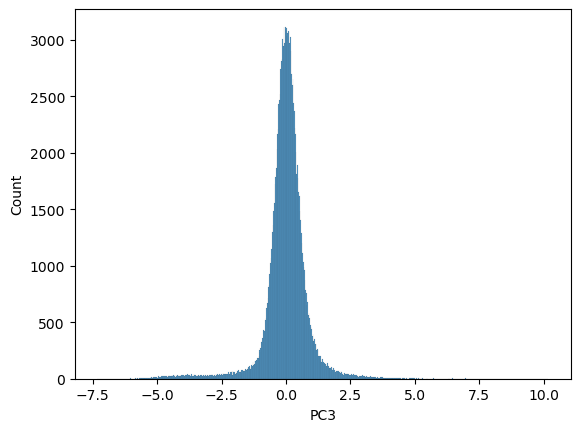

In [28]:
sns.histplot(pca_df, x='PC3')

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

ValueError: left cannot be >= right

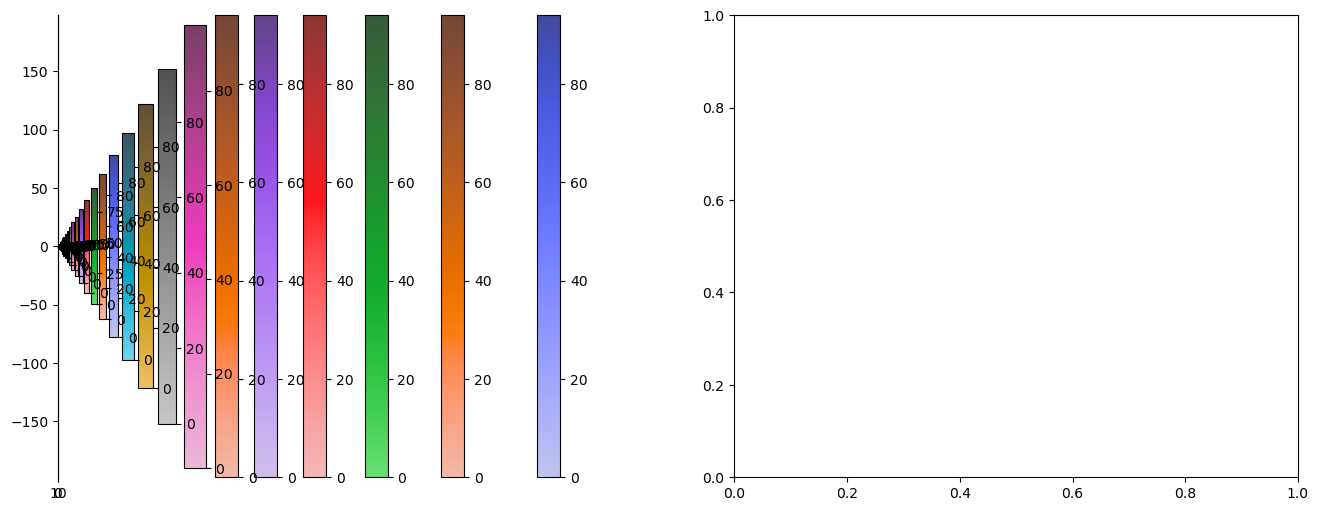

In [20]:
selectX = ['PC1',
           'PC2',
           'PC3',
           'PC4',
           'PC5',
           'PC6']


X = pca_df[selectX]

normX = (X - X.mean(axis=0))/ X.std(axis=0)

# kmeans = KMeans(n_clusters=9, random_state=0, n_init="auto", max_iter = 10000).fit(normX)
# df['label'] = kmeans.labels_

dbscan = DBSCAN(eps=0.15, min_samples= 20)
df['label'] = dbscan.fit_predict(normX)

# optics = OPTICS(min_samples=50 ) #cluster_method='dbscan', eps=0.25)
# df['label'] = optics.fit_predict(normX)

fig,  axes = plt.subplots(ncols = 2, figsize=(16,6))

ax = axes[0]
# ax.remove()  # Remove the existing second subplot
# ax = fig.add_subplot(121, projection='polar')
xlabel = 'Speed Difference (QuikSCAT - TAO)'
ylabel = 'Direction Difference (QuikSCAT - TAO)'

s = sns.histplot(df, x=xlabel, y = ylabel,#levels=10, 
                hue='label', common_norm=True, #cbar = True,
                palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')

ax.text(0.1, 0.95, 'A', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)

ax.set_xlim(-10,15)

ax = axes[1]
s = sns.countplot(df, x='label',palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')
ax.set_xlabel('cluster label')
#ax.set_ylabel('cluster label')

ax.text(0.1, 0.95, 'B', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)


#plt.savefig('PDF_byCluster_10min.png', dpi=100)